# CS 342 Final Project - Feed-forward MLP on Wine Quality Dataset

With only one

Adrian Melendez Relli - 
arm5728

In [446]:
import torch 
import csv
from torch import nn
import numpy as np
!jupyter nbextension enable --py widgetsnbextension
from tqdm.notebook import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [447]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Import data, construct test and train set

In [448]:
wine_color = 'white' #change between 'white' and 'red' at leisure
file_name = "winequality-{}.csv".format(wine_color)
df = pd.read_csv(file_name, delimiter = ";")
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [449]:
features = list(df.columns)[:-1]
labels = ['quality']

features_array = df[features].to_numpy()
labels_array = df[labels].to_numpy()

inputs = torch.Tensor(features_array)

targets = torch.Tensor(labels_array - 1)

dataset = TensorDataset(inputs, targets)

In [450]:
nrows = len(df)
val_percent = .10
val_size = int(nrows * val_percent)
train_size = nrows - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

nrows = train_size
test_percent = .15
test_size = int(nrows * test_percent)
train_size = nrows - test_size
train_data, test_data = random_split(train_data, [train_size, test_size])

# batch_size = 100
train_loader = DataLoader(train_data, shuffle = True, drop_last=True)
test_loader = DataLoader(test_data)
val_loader = DataLoader(val_data, drop_last=True)

In [451]:
input_size = len(features)
output_size = 9
print(input_size)
print(len(train_loader), len(test_loader), len(val_loader))

11
1224 216 159


Now the model

In [452]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [453]:
model = WineQuality()
print(model)
for inputs, labels in train_loader:
    print(inputs.shape)
    break

outputs = model.forward(inputs)
print(outputs.shape)

WineQuality(
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=1, bias=True)
  )
)
torch.Size([1, 11])
torch.Size([1, 1])


In [454]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [455]:
def train_network(model, train_loader, val_loader, criterion, optimizer, print_every=10, nepoch=5):
    try:
        for epoch in tqdm(range(nepoch)):
            if not (epoch%print_every):
                print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                # outputs = torch.argmax(outputs, dim=1)
                # print(outputs.shape, labels.flatten().shape)
                # print(outputs, labels.flatten())
                # print(labels.flatten().shape, outputs.shape)
                # print(outputs, labels.flatten().long())
                loss = criterion(outputs, labels.flatten())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            if not (epoch%print_every):
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    loss = criterion(outputs, labels.flatten().long())
                    total_loss += loss.item()
                    count += 1
                if not (epoch%print_every):
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode, verbose=False):
    total = 0
    sum_differences = 0
    predicted_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs) # get predicted class label for each test example.
            # print(outputs)
            # predicted = torch.argmax(outputs, dim=1)
            predicted = outputs.numpy()
            labels = labels.numpy()
            for x in range(len(predicted)):
                if (verbose):
                    # print(predicted[x], labels[x])
                    predicted_list.append(predicted[x])
                    labels_list.append(labels[x])
                total += 1
                sum_differences += abs(predicted[x] - labels[x]) 
            # print(sum_differences)
    if verbose:
        print("Visualizing classification of", len(labels_list), "test points:")
        plt.scatter(predicted_list, labels_list)
        plt.show()
    acc = (sum_differences/ total)
    print('%s average closeness: %0.3f' % (mode, acc))
    return acc

In [456]:
train_network(model, train_loader, val_loader, criterion, optimizer, 10, nepoch=100)
test_network(model, test_loader, "Model")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0


C:\Users\adria\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 Train loss: 9.56191
   Val loss: 8.84369
EPOCH 10
 Train loss: 6.48284
   Val loss: 6.06689
EPOCH 20
 Train loss: 4.41022
   Val loss: 4.20664
EPOCH 30
 Train loss: 2.93078
   Val loss: 2.88327
EPOCH 40
 Train loss: 1.95458
   Val loss: 2.01104
EPOCH 50
 Train loss: 1.34089
   Val loss: 1.45549
EPOCH 60
 Train loss: 0.97492
   Val loss: 1.11043
EPOCH 70
 Train loss: 0.75719
   Val loss: 0.89199
EPOCH 80
 Train loss: 0.63055
   Val loss: 0.75546
EPOCH 90
 Train loss: 0.56204
   Val loss: 0.67517
Model average closeness: 0.551


array([0.5506678], dtype=float32)

Visualizing classification of 216 test points:


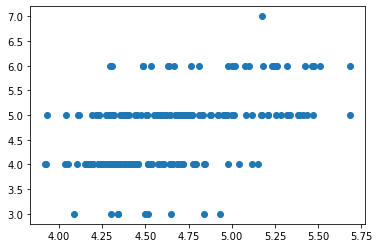

Model average closeness: 0.551


array([0.5506678], dtype=float32)

In [457]:
test_network(model, test_loader, "Model", True)

layers.0.weight tensor([[ 1.5783e-01, -6.5268e-02, -7.4294e-02,  2.7841e-02,  4.0249e-02,
         -1.0104e-02, -4.7023e-05, -1.6079e-01,  3.2617e-01,  4.1599e-01,
          2.1124e-01]])
layers.0.bias tensor([0.0616])


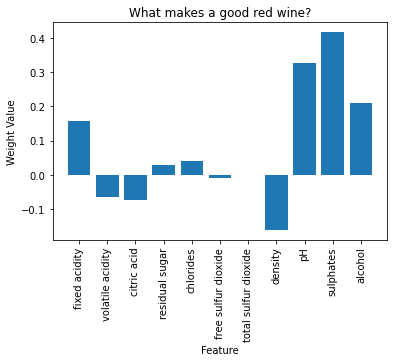

In [458]:
def visualize_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)
    weights = model.layers[0].weight.detach()[0].numpy()
    pos = np.arange(len(features))
    
    plt.bar(pos, weights)
    plt.xticks(pos, features, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Weight Value')
    plt.title('What makes a good {} wine?'.format(wine_color))
    plt.show()
    
visualize_weights(model)

Now the model with a deeper architecture

In [459]:
class WineQualityDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, input_size*2), 
            nn.PReLU(),
            nn.Linear(input_size*2, input_size*4),
            nn.PReLU(),
            nn.Linear(input_size*4, input_size*8), 
            nn.PReLU(),
            nn.Linear(input_size*8, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [460]:
model = WineQualityDeep()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [461]:
train_network(model, train_loader, val_loader, criterion, optimizer, 5, nepoch=100)
test_network(model, test_loader, "Model")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 7.92022
   Val loss: 5.19638
EPOCH 5
 Train loss: 1.04702
   Val loss: 0.81320
EPOCH 10
 Train loss: 0.53481
   Val loss: 0.60622
EPOCH 15
 Train loss: 0.50416
   Val loss: 0.60374
EPOCH 20
 Train loss: 0.49661
   Val loss: 0.60307
EPOCH 25
 Train loss: 0.49315
   Val loss: 0.60213
EPOCH 30
 Train loss: 0.48921
   Val loss: 0.59683
EPOCH 35
 Train loss: 0.48553
   Val loss: 0.59768
EPOCH 40
 Train loss: 0.48228
   Val loss: 0.60237
EPOCH 45
 Train loss: 0.48015
   Val loss: 0.60281
Exiting from training early
Model average closeness: 0.540


array([0.53995013], dtype=float32)

Visualizing classification of 216 test points:


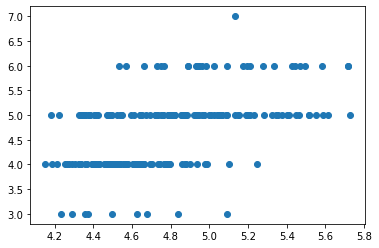

Model average closeness: 0.540


array([0.53995013], dtype=float32)

In [462]:
test_network(model, test_loader, "Model", True)